In [16]:
# library imports
import csv
import nltk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# import NDP file (~3GB of plain text)
ndp_file = "/Users/caoimherooney/Desktop/227-www-ndp-ca.txt"

In [3]:
# load the NDP plain text as a dataframe
df = pd.read_csv(ndp_file, sep = ",", usecols=[0,1,2,3], header=None, error_bad_lines=False, quoting=csv.QUOTE_NONE)
df = df.sort_values(0)

In [4]:
# there is too much data in this dataframe!
# let's focus just on the homepage
# find a homepage to focus on for the diffs
homepages = df.loc[df[2] == "http://www.ndp.ca/"]

In [36]:
# let's begin by comparing texts
# we can load the SequenceMatcher library

from difflib import SequenceMatcher
lists = [ [] for _ in range(4) ]
labels = []

In [37]:
# byte-wise metric
# compares two pages character by character
# returns 1 if there is any change at all between two pages

bytewise = []
for y in range(len(homepages)-1):
    first_page = "".join(homepages.iloc[y].tolist()) # convert webpage text into one long string
    second_page = "".join(homepages.iloc[y+1].tolist()) 
    if len(first_page) == len(second_page):
        for k in range(len(first_page)):
            if first_page[k] != second_page[k]:
                bytewise.append(1)
                break   
            elif (k == len(first_page) - 1) and (first_page[k] == second_page[k]):
                bytewise.append(0)
    else:
        bytewise.append(1)

# output is the list of metric values: either 0 (no change) or 1 (any change)
# print(bytewise)
lists[0] = bytewise
labels.append('byte-wise')

In [38]:
# TF.IDF metric
# compares the occurrence of chosen words in each page
# generates vectors weighted by such occurrences and calculates cosine distance between them

import re
import random
import numpy as np

tfidf = []
for y in range(len(homepages)-1):
    first_page = re.sub("[^\w]", " ",  "".join(homepages.iloc[y].tolist())).split()
    second_page = re.sub("[^\w]", " ",  "".join(homepages.iloc[y+1].tolist())).split()

    # generate random list of words of length >= 5 that appear in first page
    random_words = []
    for i in range(10):
        rand = random.choice(first_page)
        while len(rand) <= 4:
            rand = random.choice(first_page)    
        random_words.append(rand)
    
    # count how many times random words appear in each page
    v1 = []
    v2 = []
    for j in range(len(random_words)):
        v1.append(first_page.count(random_words[j]))
        v2.append(second_page.count(random_words[j]))
    
    if np.linalg.norm(v2) == 0:
        D = 1
    else:
        D = 1 - np.inner(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    tfidf.append(D)

# output is the list of metric values between 0 (very similar) and 1 (very different)
# print(tfidf)
lists[1] = tfidf
labels.append('TF.IDF')

In [39]:
# edit distances metric
# number of edits that are required to transform one sentence into another.
# we normalise this number by the total number of characters in each of the two pages 
# ie deleting all of page 1 and adding all of page 2

edit_distances = []
for y in range(len(homepages)-1):
    first_page = "".join(homepages.iloc[y].tolist()) # convert webpage text into one long string
    second_page = "".join(homepages.iloc[y+1].tolist()) 
    len_first = len(first_page)
    len_second = len(second_page)
    
    distance = nltk.edit_distance(first_page, second_page, transpositions=False)
    edit_distances.append(distance / (len_first + len_second))

# output is the list of metric values between 0 (very similar) and 1 (very different)
# print(edit_distances)
lists[2] = edit_distances
labels.append('edit distances')

In [40]:
# word distance metric 
# calculates how many of the words on a page have changed
# split option allows us to consider if splitting the strings into words makes a difference

word_distance = []
word_distance_split = []
for y in range (0,len(homepages)-1):
    first_page = homepages.iloc[y].tolist()
    second_page = homepages.iloc[y+1].tolist()
    seq = SequenceMatcher(None, first_page[3],second_page[3])
    seq_split = SequenceMatcher(None, first_page[3].split(),second_page[3].split())
    distance = 1-seq.ratio()
    distance_split = 1-seq_split.ratio()
    word_distance.append(distance)
    word_distance_split.append(distance_split)
    
# output is the list of metric values between 0 (very similar) and 1 (very different)
# print(word_distance)
# print(word_distance_split)
lists[3] = word_distance
#lists[4] = word_distance_split
labels.append('word distances')
#labels.append('word distances split')

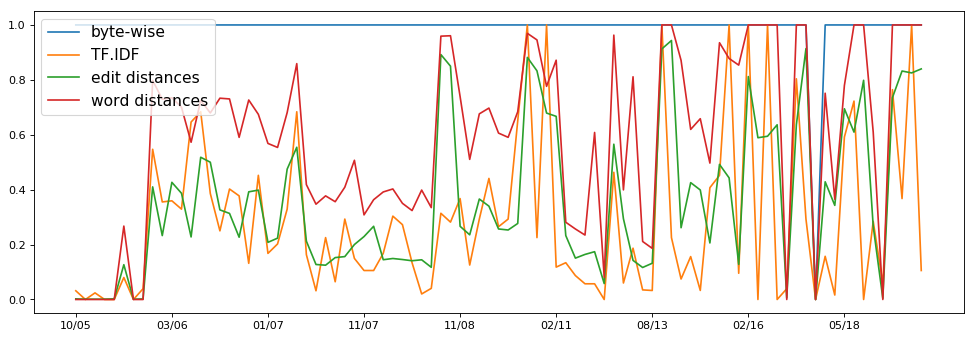

In [53]:
times = homepages[0].unique()
N = 10

plt.figure(figsize = (15,5), dpi = 80, facecolor = 'w', edgecolor = 'k')
for j in range(len(lists)):
    my_xticks = []
    for i in range (0,len(times)-1,N):
        my_xticks.append(str(times[i][5:7] + "/" + times[i][3:5]));
    plt.plot(lists[j], label = labels[j]);
    plt.xticks(range(0,len(times)-1,N), my_xticks);
    plt.legend(loc = "upper left", fontsize = 14)